In [2]:
# IPython log file
import warnings
import pathlib
import os
from glob import glob
from os.path import join
import shutil # for remove directory
#
import pathlib
import obspy
from obspy import read
import numpy as np
import pandas as pd
from obspy import Trace, UTCDateTime
from obspy.core import AttribDict
import matplotlib.pyplot as plt
#
#
path = "D:/Projects/MC20/pythoncode/"
if not os.path.exists(path+"output/"):
    os.makedirs(path+"output/", mode=0o777, exist_ok=True)
#
file = glob(path+"*.mseed")
# 
# station file name(use to add station information into sac file): 
stafn = path+"info_file/"+"sta.txt"
# event information(use to add event information into sac file)
evtfn = path+"info_file/"+"hypo.inf"
# print all the data; change to "extended=False" if data is heavy
# Create the output directory to archive based on the starttime
evtt=obspy.read(file[0]);
odir=str(evtt[0].stats.starttime).split(".")[0].replace("-","").replace(":","").replace("T",".")
odire=path+"output/"+odir
odirsac=path+"output/"+odir+"/raw_sac/"
odirmseed=path+"output/"+odir+"/raw_mseed/"
#        print(odir)
# Get the starttime of trace to make sub-directory name
if not os.path.exists(odire):
    os.makedirs(odire, mode = 0o777, exist_ok = True)
if not os.path.exists(odirsac):
    os.makedirs(odirsac, mode = 0o777, exist_ok = True)
if not os.path.exists(odirmseed):
    os.makedirs(odirmseed, mode = 0o777, exist_ok = True) 
# Uncomment when check
#print(st.__str__(extended=True))
print(" ----->>>> Extract traces from the miniseed file "+str(file))
#
###============================================================================================================###
###                              Extract the waveform data from combined mseed file:                           ###
###============================================================================================================###
for eq in file[0:1]:
#    print(eq)
    try:
        st = obspy.read(eq).merge()
            #print(path+"output/"+odir)
            #print(st[0].stats.starttime)
        for strr in st:
            #print(str)
            filename=strr.stats.network + "."+ strr.stats.station + ".." + strr.stats.channel
#            print("-->> Extract file: ",odirsac+filename,".raw.sac")
            strr.write(odirsac+filename+".raw.sac",format="SAC")
#            print("-->> Extract file: ",odirmseed+filename,".raw.mseed")
            strr.write(odirmseed+filename+".raw.mseed",format="MSEED")
#           st.plot();
    except:
        raise
        print("Error! data missing!")
#print(" ----->>>> Extract raw data finish: <<<------- ")
###============================================================================================================###
###                                     Add stations and event information:                                    ###
###      Edit the event information in hypo.inf. If event not yet to locate, used default information          ###
###============================================================================================================###
print(" ----->>>> Add the stations, event information")
# Loading station information
sdata = pd.read_csv(stafn, delim_whitespace=True, skiprows=1, names=["staname", "sla", "slo", "sdp"])
sdata.dropna(inplace=True)
# Loading station information
edata = pd.read_csv(evtfn, delim_whitespace=True, names=["y", "m", "d", "h", "mi", "s", "lo", "la", "dp", "mg"])
#
odirsaci = path+"output/"+odir+"/inf_sac"
if not os.path.exists(odirsaci):
    os.makedirs(odirsaci, mode = 0o777, exist_ok = True)
# read all sac file write out as above:
st1 = read(odirsac+"*.raw.sac")
edata_ls = edata.iloc[0, :].to_list()
for I0, I1 in enumerate(st1):
    sta = I1.copy()
#    print(f"->> {sta.stats.network} {sta.stats.station} {sta.stats.channel}")
    sdata["Indexes"] = sdata["staname"].str.find(sta.stats.station, 0)
    info = sdata[sdata["staname"] == sta.stats.station]
    if len(info) == 0:
        print(f"Found no match in station name in the file /info_file/sta.txt")
        print(f"->> " + sta.stats.network + "." +sta.stats.station)
        break
    else:
        if len(info) > 1:
#            warnings.warn(f"There are duplicates in station name in the {stafn}, plz check \n{info}", Warning)
            print(f"There are duplicates in station name in the {stafn}, plz check \n{info}")
            break
    info_list = info.iloc[0, :].to_list()
    info_list[3] = info_list[3]/1000 # convert elevation to km
    sta.stats.sac = AttribDict()
    sta.stats.sac.stla, sta.stats.sac.stlo, sta.stats.sac.stel = info_list[1:-1]
    sta.stats.sac.evla, sta.stats.sac.evlo, sta.stats.sac.evdp, sta.stats.sac.mag = edata_ls[-4:]
    sta.stats.sac.lcalda=1
    out_file = f"{sta.stats.network}.{sta.stats.station}..{sta.stats.channel}.inf.sac"
    out_file_path = join(odirsaci, out_file)
#    print(f"writing output {out_file_path}")
    sta.write(out_file_path,format="SAC")
#       
#print(" ----->>>> Add the stations, event information completed <<<------- ")            
###==========================================================================================###
###                       Remove instrument response using resp file:                        ###
###==========================================================================================###
#
#
odirsacir = path+"output/"+odir+"/sac_final"
if not os.path.exists(odirsacir):
    os.makedirs(odirsacir, mode = 0o777, exist_ok = True)
#
st2 = read(odirsaci+"/"+"VN*.inf.sac")
print(" ----->>>> Remove the instrument response")
for I0, I1 in enumerate(st2):
    sta = I1.copy()
#    print(f"->> {sta.stats.network} {sta.stats.station} {sta.stats.channel}")
    pre_filt = (0.005, 0.006, 30.0, 35.0)
    ref = f"RESP.{sta.stats.network}.{sta.stats.station}..{sta.stats.channel}"
    ref_path = path+"RESP_FILE/"+ref
#    fexist = pathlib.Path(ref_path)
#    if fexist.exists():
    if os.path.isfile(ref_path):
        seedresp = {'filename': ref_path, 'date': sta.stats.starttime, 'units': 'VEL'}
        sta.detrend("demean")
        sta.detrend("linear")
        sta.taper(max_percentage=0.05)
        sta.simulate(paz_remove=None, seedresp=seedresp)
#        sta.detrend("demean")
#        sta.detrend("linear")
#        sta.taper(max_percentage=0.05)
        #
        out_file = f"{sta.stats.network}.{sta.stats.station}..{sta.stats.channel}.removed_resp.sac"
        sta.write(odirsacir+"/"+out_file,format="SAC")
    else:
        print("Something was wrong! If no resp file! It will visit here :)) :))")
#clean the intermediaries directory:
shutil.rmtree(odirsaci, ignore_errors=True)
#
print(" ----->>>> All sac file process!!!")

 ----->>>> Extract traces from the miniseed file ['D:/Projects/MC20/pythoncode\\202008170112.mseed']
 ----->>>> Add the stations, event information
 ----->>>> Remove the instrument response
 ----->>>> All sac file process!!!


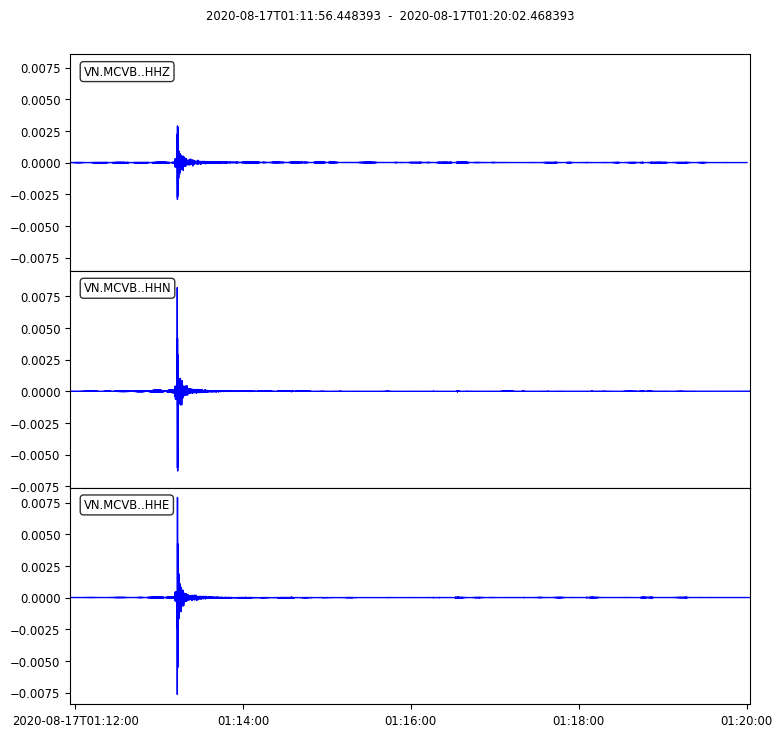

AttribDict({'delta': 0.0099999998, 'depmin': -0.0076516694, 'depmax': 0.0079014888, 'b': 0.00039299999, 'e': 485.42038, 'stla': 20.833599, 'stlo': 104.6466, 'stel': 0.83200002, 'evla': 20.938, 'evlo': 104.712, 'evdp': 7.0, 'mag': 5.0999999, 'dist': 13.413041, 'az': 210.4973, 'baz': 30.473989, 'gcarc': 0.12062638, 'depmen': -3.4811694e-06, 'nzyear': 2020, 'nzjday': 230, 'nzhour': 1, 'nzmin': 11, 'nzsec': 56, 'nzmsec': 448, 'nvhdr': 6, 'npts': 48543, 'iftype': 1, 'leven': 1, 'lpspol': 0, 'lovrok': 1, 'lcalda': 1, 'kstnm': 'MCVB', 'kcmpnm': 'HHE', 'knetwk': 'VN'})

In [3]:
# Check the output file 
from obspy.io import sac
#f = sac.SACTrace.read(odirsacir+"/"+"VN.CBVB..HHN.removed_resp.sac")
f = read(odirsacir+"/"+"VN.MCVB..HH*.removed_resp.sac")
f.plot(color='b');
f[0].stats.sac